In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
data_dir = r'/content/drive/My Drive/dataset'
pretrained_size = 300
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
train_data = datasets.ImageFolder(root = data_dir, 
                                  transform = train_transforms)

In [23]:
VALID_RATIO = 0.95

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.dataset.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [24]:
import copy

In [25]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [26]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 4412
Number of validation examples: 233


In [27]:

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size, shuffle=True)

In [28]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [29]:
def plot_images(images, labels, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = "Mask" if labels[i]==0 else "No mask"
        ax.set_title(label)
        ax.axis('off')

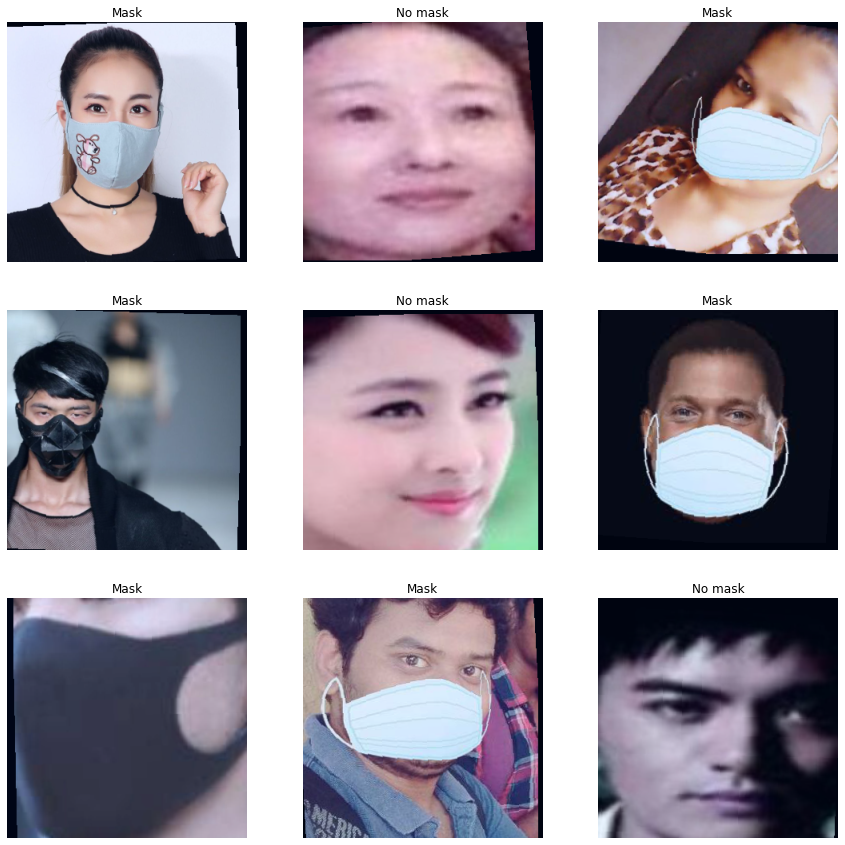

In [30]:

N_IMAGES = 15

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])



plot_images(images, labels)

In [14]:
train_data[0][0].shape

torch.Size([3, 300, 300])

In [31]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(360000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 128),
            nn.Linear(128,1)
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        x = x.view(x.size(0))
        return x 

In [32]:
import math

In [36]:
model = Net()
criterion = nn.BCELoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.003)



exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)    

In [34]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        target = target.type(torch.FloatTensor)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))

In [35]:
def evaluate(data_loader, str):
    model.eval()
    loss = 0
    correct = 0
    if str=="val":
      print("For Validation set:\n")
    else:
      print("For Train set:\n")  
    for data, target in data_loader:
          data, target = Variable(data), Variable(target)
          target = target.type(torch.FloatTensor)
          if torch.cuda.is_available():
              data = data.cuda()
              target = target.cuda()
          with torch.no_grad():
            output = model(data)
            loss += F.binary_cross_entropy(output, target).data

            pred = torch.round(output)
            
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [37]:
n_epochs = 25

for epoch in range(n_epochs):
    train(epoch)
    evaluate(valid_loader,"val")
    evaluate(train_loader,"train")
    exp_lr_scheduler.step()

Train Epoch: 0 [640/4412 (14%)]	Loss: 0.289171
Train Epoch: 0 [1280/4412 (29%)]	Loss: 0.452530
Train Epoch: 0 [1920/4412 (43%)]	Loss: 0.267379
Train Epoch: 0 [2560/4412 (58%)]	Loss: 0.362885
Train Epoch: 0 [3200/4412 (72%)]	Loss: 0.198732
Train Epoch: 0 [3840/4412 (87%)]	Loss: 0.282037
For Validation set:

Average loss: 0.0024, Accuracy: 222/233 (95.279%)

For Train set:

Average loss: 0.0032, Accuracy: 4109/4412 (93.132%)

Train Epoch: 1 [640/4412 (14%)]	Loss: 0.226942
Train Epoch: 1 [1280/4412 (29%)]	Loss: 0.138220
Train Epoch: 1 [1920/4412 (43%)]	Loss: 0.196381
Train Epoch: 1 [2560/4412 (58%)]	Loss: 0.221974
Train Epoch: 1 [3200/4412 (72%)]	Loss: 0.301488
Train Epoch: 1 [3840/4412 (87%)]	Loss: 0.164644
For Validation set:

Average loss: 0.0033, Accuracy: 215/233 (92.275%)

For Train set:

Average loss: 0.0041, Accuracy: 3942/4412 (89.347%)

Train Epoch: 2 [640/4412 (14%)]	Loss: 0.193515
Train Epoch: 2 [1280/4412 (29%)]	Loss: 0.115854
Train Epoch: 2 [1920/4412 (43%)]	Loss: 0.148921
T

In [38]:
temp = list(model.parameters())
print(len(temp))

28


In [ ]:

save_dir = r"/content/drive/My Drive/Colab Notebooks"

In [39]:
from google.colab import files


In [ ]:
torch.save(model.state_dict(), 'model.pth')

# download checkpoint file
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
path = r"/content/drive/My Drive/model_new.pth" 
torch.save(model.state_dict(), path)

In [ ]:
model2 = Net()
model2.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model2 = model2.cuda()

In [ ]:
model2 = model2.eval()

In [ ]:
temp = torch.unsqueeze(train_data[3500][0],0)
print(temp.size())
temp = temp.cuda()

torch.Size([1, 3, 300, 300])


In [ ]:
from PIL import Image

In [ ]:
img = Image.open(r"/content/drive/My Drive/images.jpg")

In [ ]:
img_tensor = test_transforms(img).unsqueeze(0)

In [ ]:
print(img_tensor.size())
img_tensor = img_tensor.cuda()

torch.Size([1, 3, 300, 300])


In [ ]:
with torch.no_grad():
  print(torch.round(model2(img_tensor)).item)

<built-in method item of Tensor object at 0x7ff4a96204c8>
